<div align="center">
    <h1><a href="index.ipynb">Knowledge Discovery in Digital Humanities</a></h1>
</div>

<div align="center">
    <h2>Class 11. Mining Twitter (continuation)</h2>
    <img src="img/twitter-logo.png" width="300">
</div>

###Table of contents

- [From previous class...](#From-previous-class...)
- [Exercises](#Exercises)

###From previous class...

In [1]:
import credentials
import tweepy

CONSUMER_KEY = credentials.TW_CONSUMER_KEY
CONSUMER_SECRET = credentials.TW_CONSUMER_SECRET
ACCESS_TOKEN = credentials.TW_ACCESS_TOKEN
ACCESS_TOKEN_SECRET = credentials.TW_ACCESS_TOKEN_SECRET

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

twitter_api = tweepy.API(auth)

# Auxiliar function to print json in a human-readable format
import json

def print_friendly_json(js):
    if isinstance(js, tweepy.models.Status):
        js = js.__dict__['_json']
    print json.dumps(js, indent=2)

###Exercises

####Exercise 1
Encapsulate the code for search tweets from the previous class in a function named `search_tweets` that receive three arguments: the query, the count of maximum tweets retrieved by each search on Twitter and the number of extra iterations. The function must return the tweets found.

In [2]:
def search_tweets(q, count, extra_iters):
    search_results = twitter_api.search(q=q, count=count)
    tweets = search_results
    print "Total tweets retrieved:", len(tweets)

    # Iterate through 5 more batches of results by following the cursor
    for _ in range(extra_iters):
        next_results = search_results.next_results
        # No more results when next_results is None
        # If next_results exists, search again
        # next_results has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        # Unpacking the values in a dictionary into keyword arguments
        # for the next search
        if next_results:
            kwargs = dict([ kw.split('=') for kw in next_results[1:].split("&") ])
            search_results = twitter_api.search(**kwargs)
            tweets += search_results
            print "Total tweets retrieved:", len(tweets)
    return tweets

####Exercise 2
Search the tweets for `@tasteofhome`, with a count of `100`, and `3` extra iterations and assign the results to the variable `toh_tweets`. Filter the tweets published by `@tasteofhome`.

In [3]:
toh_tweets = search_tweets('@tasteofhome', 100, 3)
toh_tweets = filter(lambda x: x.author.screen_name != 'tasteofhome', toh_tweets)
print 'Tweets not published by @tasteofhome:', len(toh_tweets)

Total tweets retrieved: 75
Tweets not published by @tasteofhome: 68


####Exercise 3
Extract the list of authors, mentioned users, hashtags, and words from the tweets. Print the first 5 items for each.

In [4]:
authors = [t.author.screen_name for t in toh_tweets]
mentioned_users = [user_mention['screen_name']
                    for t in toh_tweets
                         for user_mention in t.entities['user_mentions']
               ]
hashtags = [hashtag['text'] 
               for t in toh_tweets
                   for hashtag in t.entities['hashtags']
           ]
words = [w for t in toh_tweets
             for w in t.text.split()
        ]

print 'Authors:'
print_friendly_json(authors[:5])
print 'Mentioned users:'
print_friendly_json(mentioned_users[:5])
print 'Hashtags:'
print_friendly_json(hashtags[:5])
print 'Words:'
print_friendly_json(words[:5])

Authors:
[
  "Acadia_Baby", 
  "newsGSEOK", 
  "giveawayBig565", 
  "dinner4moms", 
  "MeridianTech"
]
Mentioned users:
[
  "tasteofhome", 
  "tasteofhome", 
  "EnjoyGalenaCtry", 
  "tasteofhome", 
  "tasteofhome"
]
Hashtags:
[
  "Galena", 
  "enjoyillinois", 
  "Galena", 
  "enjoyillinois", 
  "Galena"
]
Words:
[
  "40", 
  "Minute", 
  "Hamburger", 
  "Buns", 
  "from"
]


####Exercise 4
Create a frequency distribution from the previous hashtags. Use the function `histogram` (name it `my_histogram`) defined in [the exercise 4 of the class 10](class10.ipynb#Exercise-4).

In [5]:
def my_histogram(sequence):
    d = {}
    for elem in sequence:
        if elem in d:
            d[elem] += 1
        else:
            d[elem] = 1
    return d

toh_hashtags_hist = my_histogram(hashtags)

####Exercise 5
Visualize the histogram of the hashtag frequency distribution with Pandas. Use the function `filter_ascii` first to filter all the non ascii keys from the dictionary of hashtags.

In [6]:
def filter_ascii(d):
    d2 = {}
    for k in d:
        try:
            k2 = str(k)
            d2[k2] = d[k]
        except:
            pass
    return d2

toh_hashtags_hist = filter_ascii(toh_hashtags_hist)

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams.update({'figure.autolayout': True})
font = {'size': 12}
matplotlib.rc('font', **font)

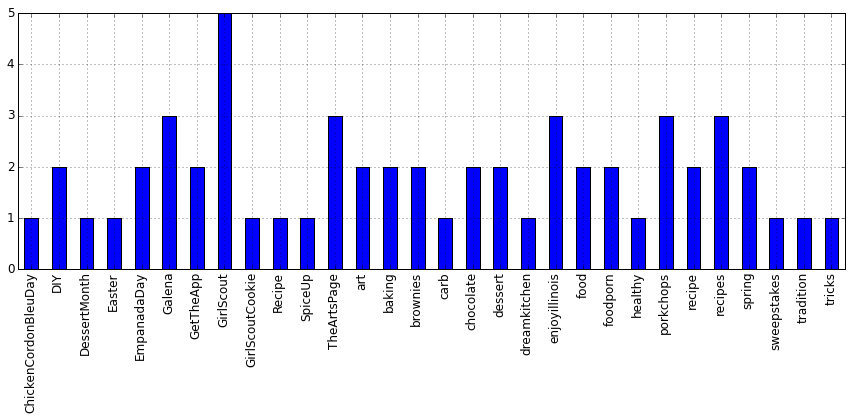

In [9]:
import pandas as pd

toh_hashtags_sr = pd.Series(toh_hashtags_hist)
toh_hashtags_sr.plot(kind='bar')

####Exercise 6
Compare the previous hashtag distribution to the distribution of hashtags used by `@tasteofhome` in its own tweets.

1. Get the list of the 20 most recent tweets published by `@tasteofhome` and assign it to the variable `tweets_by_toh`
2. Extract all the hashtags
2. Create a frequency distribution from the previous hashtags
3. Visualize the new distribution
4. Visualize and compare both distributions

In [10]:
tweets_by_toh = twitter_api.user_timeline('@tasteofhome')

In [11]:
hashtags_by_toh = [hashtag['text'] 
                       for t in tweets_by_toh
                           for hashtag in t.entities['hashtags']
                   ]

In [12]:
hashtags_by_toh_hist = my_histogram(hashtags_by_toh)
hashtags_by_toh_hist = filter_ascii(hashtags_by_toh_hist)

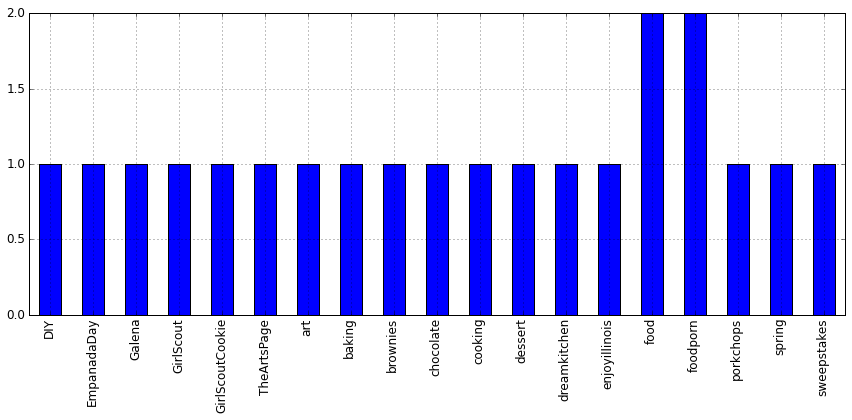

In [13]:
hashtags_by_toh_sr = pd.Series(hashtags_by_toh_hist)
hashtags_by_toh_sr.plot(kind='bar')

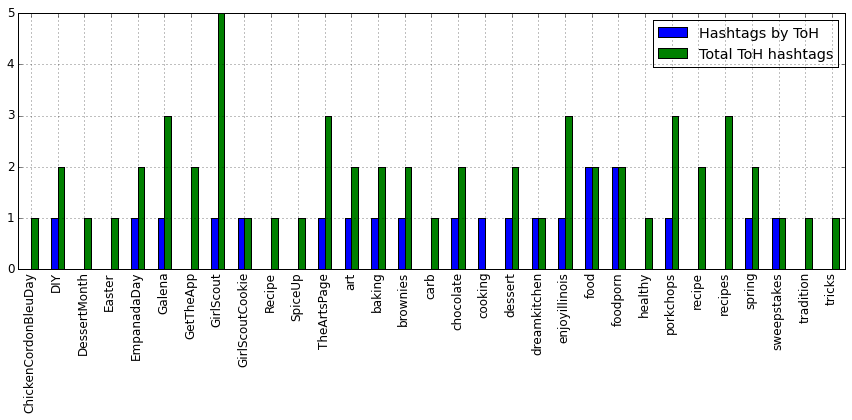

In [14]:
hashtags_df = pd.DataFrame({
        'Total ToH hashtags': toh_hashtags_sr,
        'Hashtags by ToH': hashtags_by_toh_sr
    })
hashtags_df.plot(kind='bar')

####Exercise 7
What conclusions can we draw from the last figure?

*The set of hashtags (except one, cooking) used by `@tasteofhome` is included in the set of hashtags used by its community. This means that the community of Taste of Home assumes and extends the vocabulary (hashtags) used by `@tasteofhome`.*